In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/rba-dataset.zip

Archive:  /content/drive/MyDrive/rba-dataset.zip
  inflating: LICENSE                 
  inflating: README.md               
  inflating: RESULTS.md              
   creating: images/
  inflating: images/login-overview.png  
  inflating: images/rq1-general.png  
  inflating: images/rq1-login-frequency.png  
  inflating: images/rq2-attack-data.png  
  inflating: images/rq6-rtt-0_999.png  
  inflating: images/rtts-continents.png  
  inflating: images/rtts-global.png  
  inflating: rba-dataset.csv         


# Import Section
First, we import/install all required libraries and packages needed for data processing, modeling, evaluation, and visualization.

In [3]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from scipy.optimize import brentq
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
import time

# Load Training and Testing Subsets
This cell loads two disjoint subsets from the same CSV file.

In [5]:
print("Loading training subset...")
df_train = pd.read_csv("/content/rba-dataset.csv", nrows=100000)

print("Loading testing subset...")
# Skip the header and first 50,000 rows (adjust if necessary)
df_test = pd.read_csv("/content/rba-dataset.csv", skiprows=range(1,100001), nrows=100000)

Loading training subset...
Loading testing subset...


# Data Preparation & Feature Engineering (Training Subset)
This cell processes the training subset: filling missing values, engineering a time-based feature, and flipping the target label.

In [6]:
print("Preprocessing training data...")

# Define the features
features = ["Country", "Region", "City", "ASN", "User Agent String",
            "Browser Name and Version", "OS Name and Version", "Device Type"]

# Fix missing values
df_train[features] = df_train[features].fillna("missing")

# Convert timestamp to datetime and sort by time
df_train["Login Timestamp"] = pd.to_datetime(df_train["Login Timestamp"])
df_train = df_train.sort_values("Login Timestamp")

# Create time-based feature
df_train["time_since_last_login"] = df_train.groupby("User ID")["Login Timestamp"].diff().dt.total_seconds().fillna(0)
features.append("time_since_last_login")

# Drop rows with missing target values
df_train = df_train.dropna(subset=["Login Successful"])

# Flip target: Attack = 1 - Login Successful (so Attack=1 indicates an attack)
df_train["Attack"] = 1 - df_train["Login Successful"]

# Ensure categorical features are strings
df_train[features[:-1]] = df_train[features[:-1]].astype(str)

Preprocessing training data...


#Data Preparation & Feature Engineering (Testing Subset)
This cell performs the same preprocessing for the testing subset.

In [7]:
print("Preprocessing testing data...")

df_test[features[:-1]] = df_test[features[:-1]].fillna("missing")
df_test["Login Timestamp"] = pd.to_datetime(df_test["Login Timestamp"])
df_test = df_test.sort_values("Login Timestamp")
df_test["time_since_last_login"] = df_test.groupby("User ID")["Login Timestamp"].diff().dt.total_seconds().fillna(0)

# Make sure target is not missing
df_test = df_test.dropna(subset=["Login Successful"])

# Flip target: Attack = 1 - Login Successful
df_test["Attack"] = 1 - df_test["Login Successful"]

# Ensure categorical features are strings
df_test[features[:-1]] = df_test[features[:-1]].astype(str)

Preprocessing testing data...


#Target Encoding and Split (Using Preprocessed Train/Test)
This cell applies Target Encoding on the training data and then transforms the testing data using the fitted encoder.

In [8]:
encoder = TargetEncoder(smoothing=100)
X_train = df_train[features]
y_train = df_train["Attack"].astype(int)
X_test = df_test[features]
y_test = df_test["Attack"].astype(int)

X_train_enc = encoder.fit_transform(X_train, y_train).values
X_test_enc = encoder.transform(X_test).values

#Validate Data Integrity
This cell checks that there are no NaNs after encoding.

In [9]:
assert not np.any(np.isnan(X_train_enc)), "NaNs in training data!"
assert not np.any(np.isnan(X_test_enc)), "NaNs in test data!"

#Handle Class Imbalance
This cell balances the training data using SMOTETomek.

In [10]:
print("Balancing training classes with SMOTETomek...")
smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X_train_enc, y_train)

Balancing training classes with SMOTETomek...


#Advanced Anomaly Detection
This cell trains the anomaly detectors (LOF and Isolation Forest) on the balanced training data and obtains anomaly scores for both train and test sets.

In [11]:
print("Training anomaly detectors...")

lof = LocalOutlierFactor(n_neighbors=35, contamination=0.01, novelty=True, metric='cosine')
lof.fit(X_res)
lof_scores_train = lof.decision_function(X_res).reshape(-1, 1)
lof_scores_test = lof.decision_function(X_test_enc).reshape(-1, 1)

iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(X_res)
iso_scores_train = iso_forest.decision_function(X_res).reshape(-1, 1)
iso_scores_test = iso_forest.decision_function(X_test_enc).reshape(-1, 1)

# Combine anomaly scores equally
train_anomaly_scores = (lof_scores_train + iso_scores_train) / 2
test_anomaly_scores = (lof_scores_test + iso_scores_test) / 2

Training anomaly detectors...


#Final Feature Matrix
This cell appends the combined anomaly scores to the encoded features for both training and testing sets.

In [12]:
X_train_final = np.hstack([X_res, train_anomaly_scores])
X_test_final = np.hstack([X_test_enc, test_anomaly_scores])

#Optimized Model Training
This cell trains the LightGBM classifier (with calibrated probabilities) on the training set.


In [13]:
print("Training classifier...")
base_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=7,           # Increased depth for more complex splits
    reg_alpha=0.3,
    reg_lambda=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight={0: 1, 1: 2.5},  # Attack=1 is upweighted
    min_child_samples=20,
    random_state=42
)

# Calibrate model probabilities using sigmoid calibration (suitable for imbalanced data)
calibrated = CalibratedClassifierCV(base_model, method='sigmoid', cv=5)
calibrated.fit(X_train_final, y_res)

Training classifier...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 38376, number of negative: 38377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1965
[LightGBM] [Info] Number of data points in the train set: 76753, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.714280 -> initscore=0.916265
[LightGBM] [Info] Start training from score 0.916265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 38377, number of negative: 38376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1954
[LightGBM] [Info] Number of data points in the train set: 76753, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.714291 -> initscore=0.916317
[LightGBM] [Info] Start training from score 0.916317


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 38377, number of negative: 38377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1937
[LightGBM] [Info] Number of data points in the train set: 76754, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.714286 -> initscore=0.916291
[LightGBM] [Info] Start training from score 0.916291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 38377, number of negative: 38377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1962
[LightGBM] [Info] Number of data points in the train set: 76754, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.714286 -> initscore=0.916291
[LightGBM] [Info] Start training from score 0.916291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 38377, number of negative: 38377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 76754, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.714286 -> initscore=0.916291
[LightGBM] [Info] Start training from score 0.916291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(class_weight={0: 1, 1: 2.5},
                                                colsample_bytree=0.8,
                                                learning_rate=0.02, max_depth=7,
                                                n_estimators=500,
                                                random_state=42, reg_alpha=0.3,
                                                reg_lambda=0.1, subsample=0.8))

#Prediction & Threshold Optimization
This cell generates predictions on the testing set, computes the ROC curve, and selects the optimal threshold using a discrete method (minimizing |FPR - FRR|). It then prints key metrics, as well as plots the FAR vs. FRR curve with the selected threshold, the confusion matrix, and the ROC curve.

Generating predictions...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Classification Report (Attack=1, Legit=0):
              precision    recall  f1-score   support

       Legit       0.79      0.80      0.80     48755
      Attack       0.81      0.80      0.81     51245

    accuracy                           0.80    100000
   macro avg       0.80      0.80      0.80    100000
weighted avg       0.80      0.80      0.80    100000

AUC-ROC: 0.8721
Optimal Threshold (Youden's J): 0.3346
Equal Error Rate (EER): 0.1982


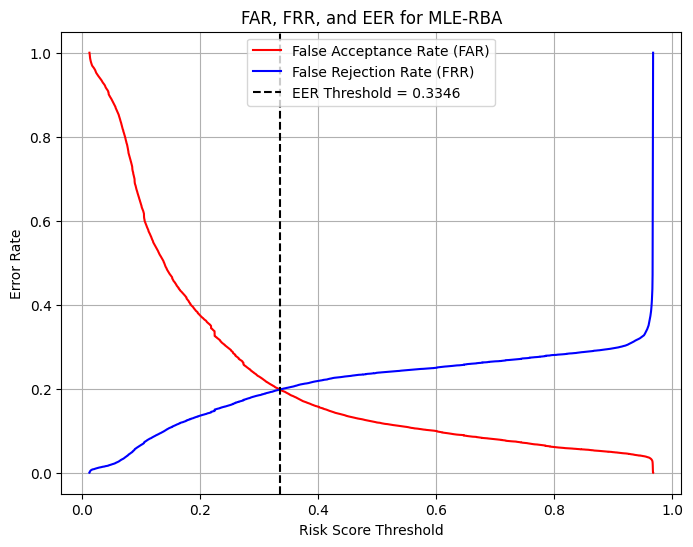

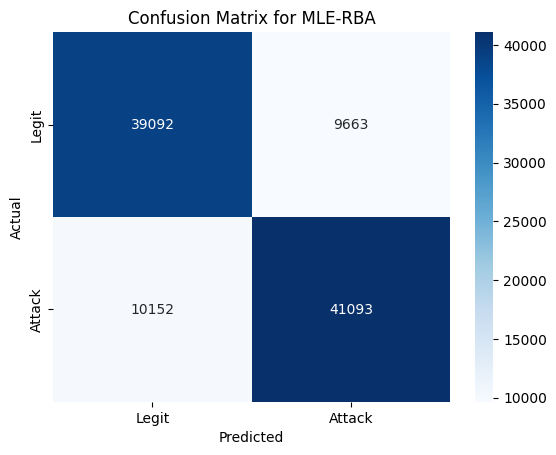

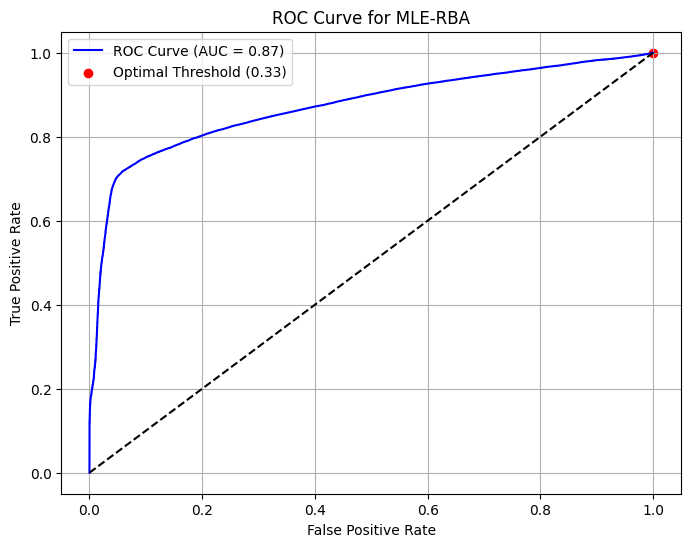

Processing complete.


In [15]:
print("Generating predictions...")
test_probs = calibrated.predict_proba(X_test_final)[:, 1]  # Probability of Attack

# Compute ROC curve and error rates
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
frr = 1 - tpr

# Discrete threshold selection: choose threshold minimizing |FPR - FRR|
diff = np.abs(fpr - frr)
eer_index = np.argmin(diff)
eer_threshold = thresholds[eer_index]
eer = (fpr[eer_index] + frr[eer_index]) / 2

# Final classification using the chosen threshold
y_pred = (test_probs >= eer_threshold).astype(int)

print("\nClassification Report (Attack=1, Legit=0):")
print(classification_report(y_test, y_pred, target_names=["Legit", "Attack"]))
print(f"AUC-ROC: {roc_auc_score(y_test, test_probs):.4f}")
print(f"Optimal Threshold (Youden's J): {eer_threshold:.4f}")
print(f"Equal Error Rate (EER): {eer:.4f}")
# --------------------
# Visualization
# --------------------
# FAR vs FRR Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fpr, label="False Acceptance Rate (FAR)", color="red")
plt.plot(thresholds, frr, label="False Rejection Rate (FRR)", color="blue")
plt.axvline(eer_threshold, color="black", linestyle="--", label=f"EER Threshold = {eer_threshold:.4f}")
plt.xlabel("Risk Score Threshold")
plt.ylabel("Error Rate")
plt.legend()
plt.title("FAR, FRR, and EER for MLE-RBA")
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legit", "Attack"],
            yticklabels=["Legit", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for MLE-RBA")
plt.show()

# ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, test_probs):.2f})", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.scatter(np.interp(eer_threshold, thresholds, fpr), np.interp(eer_threshold, thresholds, tpr),
            color="red", label=f"Optimal Threshold ({eer_threshold:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for MLE-RBA")
plt.legend()
plt.grid(True)
plt.show()

print("Processing complete.")